In [1]:
# LIBRARIES
## basics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## api/fred
import json
import requests

## yfinance api
import yfinance as yf

## Functions

### Get functions

In [2]:
def timeseries_add_diffNreturn(timeseries_data):
    """adds price difference datapoints from the last close AND return from last datapoint"""
    #! kolla så att close.diff gör rätt sak. 
    timeseries_data["Price_Diff"] = timeseries_data["Close"].diff()
    timeseries_data["Total_Return"] = timeseries_data["Price_Diff"] / timeseries_data["Close"].shift(1)
    return timeseries_data

In [3]:
def get_timeseries_yfinance(ticker_symbol="^GSPC", period="max", interval="1wk"):
    """laddar hem och returnar en ticker utifrån specifierade variabler"""
    timeseries_data = yf.download(ticker_symbol, period = period, interval = interval) 
    timeseries_data = timeseries_add_diffNreturn(timeseries_data)
    return timeseries_data

In [4]:
def get_fred_data(series_id="M2SL", frequency="m"):
    """returns total history of m2 money supply in a dataframe in BILLIONS of dollars"""
    api_key="XXXXXXXXXXXX"

    #^ specifying series & api_key in url
    series_id = series_id
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&frequency={frequency}"
    
    #^ getting data
    response = requests.get(url)
    data = response.json()

    #^ return dataframe with 
    df = pd.DataFrame(data["observations"])
    return df

### Calculate Functions

In [5]:
def normalize_timeseries(yfinance_series, fred_series, from_date=1959, to_date=2023):
    """compares dates and normalizes them to the same start and finish date, same amount of data points"""

    #^ loc for from_date
    #~ yfinance är första kolumnnen date
    ## vid 1927-12-26, 
    yfinance_series = yfinance_series.reset_index()
    yfinance_series = yfinance_series.loc[((yfinance_series["Date"].dt.year >= from_date) & (yfinance_series["Date"].dt.year <= to_date))]
    
    #^ adjusting to correct data types and same from_date
    #~ fred är 3de kolumnen date
    ## vid 1959-01-01
    fred_series.drop(columns=["realtime_start", "realtime_end"],inplace=True)
    fred_series["date"] = pd.to_datetime(fred_series['date'])
    fred_series["value"] = pd.to_numeric(fred_series["value"])
    fred_series = fred_series.loc[((fred_series["date"].dt.year >= from_date) & (fred_series["date"].dt.year <= to_date))]
    fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)

    #^ returns both adjusted series, same starting date and 
    return yfinance_series, fred_series

In [11]:
def normalize_fred_data(fred_series, from_date=1959, to_date=2023):
    fred_series.drop(columns=["realtime_start", "realtime_end"],inplace=True)
    fred_series["date"] = pd.to_datetime(fred_series['date'])
    fred_series["value"] = pd.to_numeric(fred_series["value"])
    fred_series = fred_series.loc[((fred_series["date"].dt.year >= from_date) & (fred_series["date"].dt.year <= to_date))]
    fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
    return fred_series

In [7]:
def correlation_diff_scales(ticker_data, fred_data):
    asof_merged_data = merge_data(ticker_data, fred_data)
    return asof_merged_data["Close"].corr(asof_merged_data["value"]) #! ksk behöver vara columns index istället

In [8]:
def merge_data(ticker_data, fred_data):
    asof_merged_data = pd.merge_asof(ticker_data[["Date", "Close"]].sort_values('Date'), fred_data.sort_values('Date'), on='Date', direction='nearest')
    return asof_merged_data

In [9]:
def normalize_timeseries(yfinance_series, fred_series, from_date=2019, to_date=2023):
    """compares dates and normalizes them to the same start and finish date, same amount of data points"""

    #^ loc for from_date
    #~ yfinance är första kolumnnen date
    ## vid 1927-12-26, 
    yfinance_series = yfinance_series.reset_index()
    yfinance_series = yfinance_series.loc[((yfinance_series["Date"].dt.year >= from_date) & (yfinance_series["Date"].dt.year <= to_date))]
    
    #^ adjusting to correct data types and same from_date
    #~ fred är 3de kolumnen date
    ## vid 1959-01-01
    fred_series.drop(columns=["realtime_start", "realtime_end"],inplace=True)
    fred_series["date"] = pd.to_datetime(fred_series['date'])
    fred_series["value"] = pd.to_numeric(fred_series["value"])
    fred_series = fred_series.loc[((fred_series["date"].dt.year >= from_date) & (fred_series["date"].dt.year <= to_date))]
    fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)

    #^ returns both adjusted series, same starting date and 
    return yfinance_series, fred_series

## Visualisation, getting graphs

### m2 VS sp500

In [10]:
# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
ticker = "^GSPC"
fred_ticker = "M2SL"  #M2SL, 

#time interval
from_date=2017
to_date=2023

# get chosen tickers data
ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker)

# normalize time intervall in both series
ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)

[*********************100%%**********************]  1 of 1 completed


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3444765313.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\2284483504.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

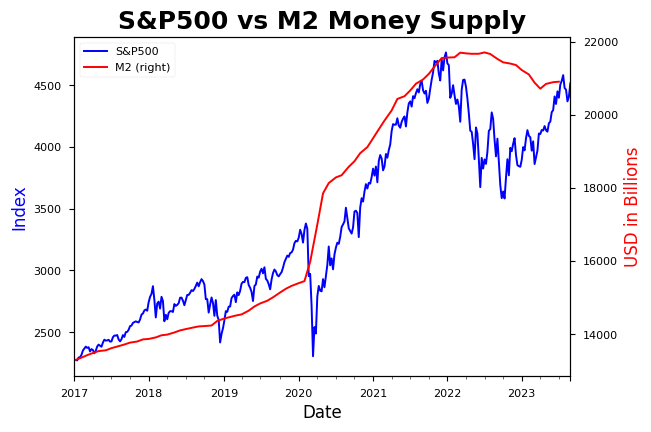

In [11]:
# labels
ticker_symbol = "S&P500" ##legend
fred_symbol = "M2" ##legend
ticker_ylabel = "Index"
fred_ylabel = "USD in Billions"

# colours
color1 = "Blue"
color2 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = ticker_data.plot(kind='line', x='Date', y='Close', label=ticker_symbol, color=color1)
ax2 = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, secondary_y=True, ax=ax, color=color2)


ax.set_ylabel(ticker_ylabel, color=color1, fontsize=12)
ax2.set_ylabel(fred_ylabel, color=color2, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('S&P500 vs M2 Money Supply', fontsize=18, fontweight='bold') 
plt.show()

In [12]:
fred_data['value'].max()


21703.6

In [13]:
fred_data.loc[fred_data["Date"].dt.year == 2020] # 2020-03-01 var då dem sänkte rates, 15978.7

,Date,value
732,2020-01-01,15396.0
733,2020-02-01,15450.3
734,2020-03-01,15978.7
735,2020-04-01,16997.6
736,2020-05-01,17851.1
737,2020-06-01,18131.7
738,2020-07-01,18286.3
739,2020-08-01,18346.0
740,2020-09-01,18577.3
741,2020-10-01,18729.1


In [14]:
21703.6/15978.7

1.358283214529342

### fed VS sp500

In [15]:
# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
ticker = "^GSPC"
fred_ticker = "DFF"  #M2SL, 

#time interval
from_date=2019
to_date=2023

# get chosen tickers data
ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker)

# normalize time intervall in both series
ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)

[*********************100%%**********************]  1 of 1 completed


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3444765313.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\2766435887.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

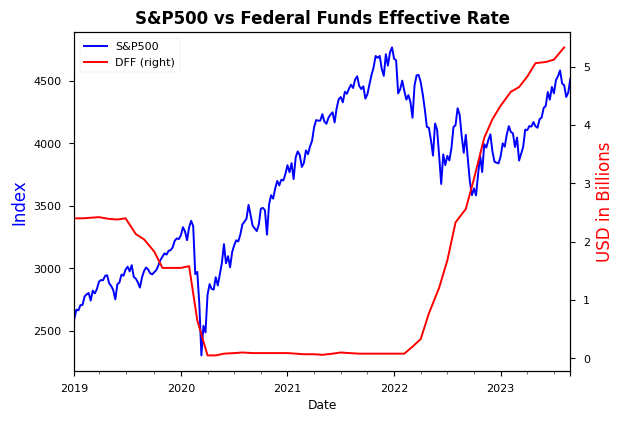

In [16]:
# labels
ticker_symbol = "S&P500" ##legend
fred_symbol = "DFF" ##legend
ticker_ylabel = "Index"
fred_ylabel = "USD in Billions"

# colours
color1 = "Blue"
color2 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = ticker_data.plot(kind='line', x='Date', y='Close', label=ticker_symbol, color=color1)
ax2 = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, secondary_y=True, ax=ax, color=color2)


ax.set_ylabel(ticker_ylabel, color=color1, fontsize=12)
ax2.set_ylabel(fred_ylabel, color=color2, fontsize=12)

plt.title('S&P500 vs Federal Funds Effective Rate', fontsize=12, fontweight='bold') 
plt.show()

In [17]:
fred_data.loc[fred_data["Date"].dt.year == 2020]

,Date,value
786,2020-01-01,1.55
787,2020-02-01,1.58
788,2020-03-01,0.65
789,2020-04-01,0.05
790,2020-05-01,0.05
791,2020-06-01,0.08
792,2020-07-01,0.09
793,2020-08-01,0.10
794,2020-09-01,0.09
795,2020-10-01,0.09


### m2 money supply

In [55]:
# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
ticker = "^GSPC"
fred_ticker = "M2SL"  #M2SL, DFF

#time interval
from_date=2018
to_date=2023

# get chosen tickers data
ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker)

# normalize time intervall in both series
ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)

[*********************100%%**********************]  1 of 1 completed


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3444765313.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3236231181.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

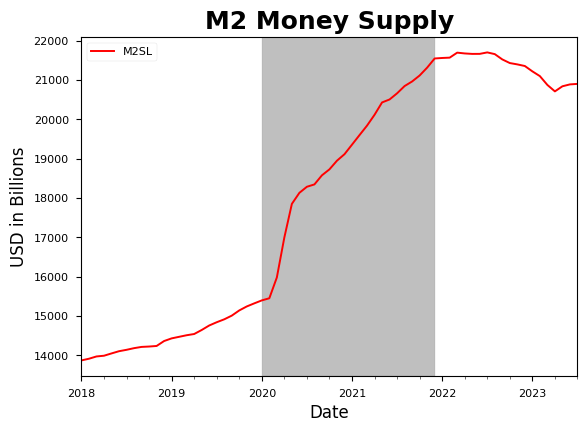

In [56]:
# labels
fred_symbol = "M2SL" ##legend
fred_ylabel = "USD in Billions"

# colours
color1 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')

# ... (code to get data and set up plot)

# Add shaded region to highlight the specified dates
ax.axvspan(start_date, end_date, color='grey', alpha=0.5)

# ... (rest of the code to complete and show the plot)


ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('M2 Money Supply', fontsize=18, fontweight='bold') 
plt.show()

### m2 VS dff

In [40]:
# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
fred_ticker1 = "DFF"
fred_ticker2 = "M2SL"  #M2SL, DFF

#time interval
from_date=2018
to_date=2023

# get chosen tickers data
#ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker1)
fred_data2 = get_fred_data(fred_ticker2)

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, 2018, 2023)
fred_data2 = normalize_fred_data(fred_data2, 2018, 2023)



C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\2033965968.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

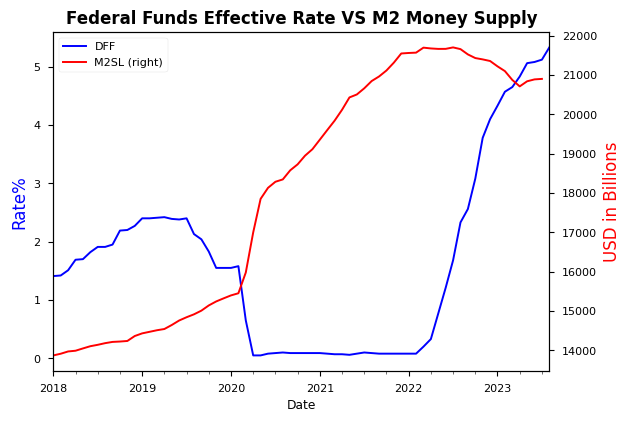

In [41]:
# labels
fred_symbol = "DFF" ##legend
fred_symbol2 = "M2SL" ##legend

fred_ylabel = "Rate%"
fred_ylabel2 = "USD in Billions"

# colours
color1 = "Blue"
color2 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)
ax2 = fred_data2.plot(kind='line', x='Date', y='value', label=fred_symbol2, secondary_y=True, ax=ax, color=color2)


ax.set_ylabel(fred_ylabel, color=color1, fontsize=12)
ax2.set_ylabel(fred_ylabel2, color=color2, fontsize=12)

plt.title('Federal Funds Effective Rate VS M2 Money Supply', fontsize=12, fontweight='bold') 
plt.show()

### top1% vs bottom 90%

In [53]:
## ha med en liten graph under med själva total trender på https://fred.stlouisfed.org/series/MEHOINUSA672N

# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
fred_ticker1 = "MEHOINUSA672N"
fred_ticker2 = "M2SL"  #M2SL, DFF

#time interval
from_date=2018
to_date=2023

# get chosen tickers data
#ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "a")
fred_data2 = get_fred_data(fred_ticker2)

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, 2018, 2023)
fred_data2 = normalize_fred_data(fred_data2, 2018, 2023)




C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3475227564.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

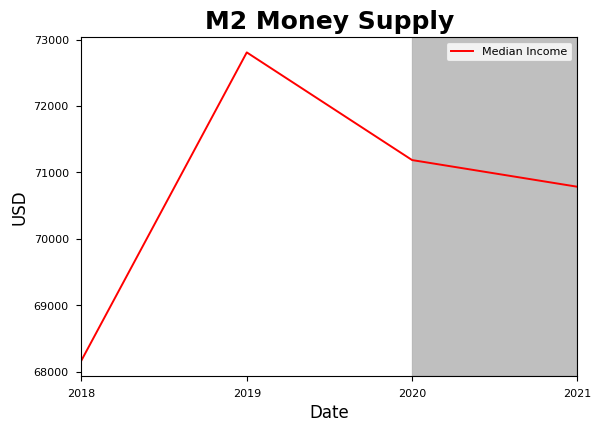

In [54]:
# labels
fred_symbol = "Median Income" ##legend
fred_ylabel = "USD"

# colours
color1 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')

# ... (code to get data and set up plot)

# Add shaded region to highlight the specified dates
ax.axvspan(start_date, end_date, color='grey', alpha=0.5)

# ... (rest of the code to complete and show the plot)


ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('M2 Money Supply', fontsize=18, fontweight='bold') 
plt.show()

### göra en med top 1% net worth och vanliga människors savings

In [62]:
## ha med en liten graph under med själva total trender på https://fred.stlouisfed.org/series/MEHOINUSA672N

# input time interval AND period
interval = "1wk"
period = "max"

#input ticker and fred_ticker
fred_ticker1 = "WFRBST01134"
fred_ticker2 = "M2SL"  #M2SL, DFF

#time interval
from_date=2018
to_date=2023

# get chosen tickers data
#ticker_data = get_timeseries_yfinance(ticker_symbol=ticker, period=period, interval=interval)

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "q")
fred_data2 = get_fred_data(fred_ticker2)

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, 2018, 2023)
fred_data2 = normalize_fred_data(fred_data2, 2018, 2023)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_592\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)


C:\Users\erik_\AppData\Local\Temp\ipykernel_592\3380335182.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

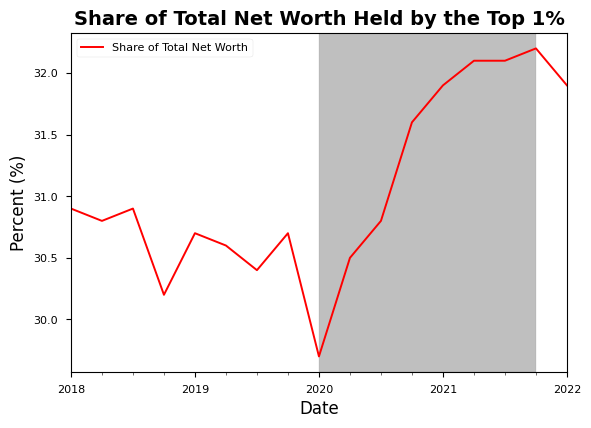

In [63]:
# labels
fred_symbol = "Share of Total Net Worth" ##legend
fred_ylabel = "Percent (%)"

# colours
color1 = "Red"

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
# Add shaded region to highlight the specified dates
ax.axvspan(start_date, end_date, color='grey', alpha=0.5)

#more labels
ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('Share of Total Net Worth Held by the Top 1%', fontsize=14, fontweight='bold') 
plt.show()

### top 1% vs bottom 50%

C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\333170575.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain 

<Figure size 2000x1000 with 0 Axes>

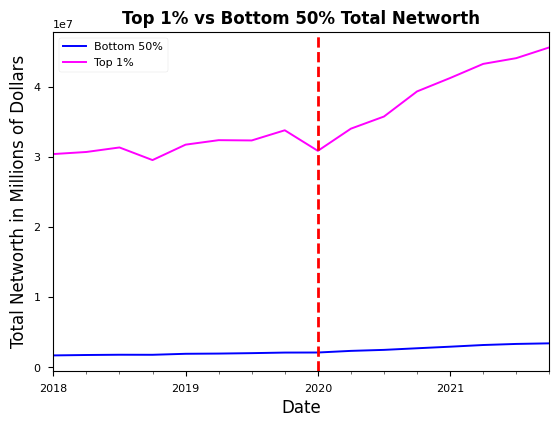

In [44]:
#fred_tickers
fred_ticker1 = "WFRBLB50107"  #bottom 50%
fred_ticker2 = "WFRBLT01026"  #top 1%

#time interval
from_date=2018
to_date=2021

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "q")
fred_data2 = get_fred_data(fred_ticker2, "q")

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, from_date=from_date, to_date=to_date)
fred_data2 = normalize_fred_data(fred_data2, from_date=from_date, to_date=to_date)




# labels
fred_symbol = "Bottom 50%" ##legend
fred_symbol2 = "Top 1%" ##legend

fred_ylabel = "Total Networth in Millions of Dollars"

# colours
color1 = "Blue"
color2 = "magenta" # if change this to invalid you get only the other graph

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)
ax2 = fred_data2.plot(kind='line', x='Date', y='value', label=fred_symbol2, ax=ax, color=color2)

plt.axvline(x='2020-01-01', color='r', linestyle='--', linewidth=2)

ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('Top 1% vs Bottom 50% Total Networth', fontsize=12, fontweight='bold') 
plt.show()

C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\2843144033.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain

<Figure size 2000x1000 with 0 Axes>

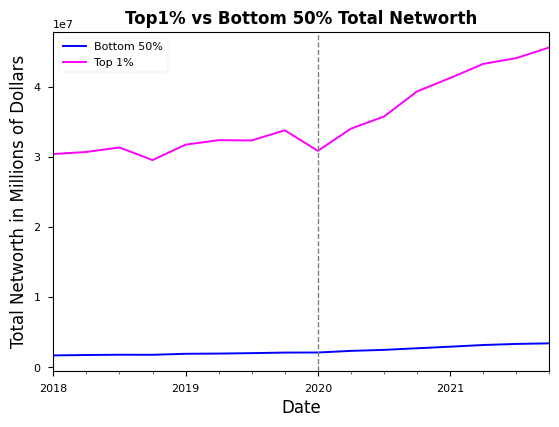

In [55]:
#fred_tickers
fred_ticker1 = "WFRBLB50107"  #bottom 50%
fred_ticker2 = "WFRBLT01026"  #top 1%

#time interval
from_date=2018
to_date=2021

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "q")
fred_data2 = get_fred_data(fred_ticker2, "q")

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, from_date=from_date, to_date=to_date)
fred_data2 = normalize_fred_data(fred_data2, from_date=from_date, to_date=to_date)




# labels
fred_symbol = "Bottom 50%" ##legend
fred_symbol2 = "Top 1%" ##legend

fred_ylabel = "Total Networth in Millions of Dollars"

# colours
color1 = "Blue"
color2 = "magenta" # if change this to invalid you get only the other graph

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)
ax2 = fred_data2.plot(kind='line', x='Date', y='value', label=fred_symbol2, ax=ax, color=color2)

plt.axvline(x='2020-01-01', color='grey', linestyle='--', linewidth=1)

ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

#^ different titles here
plt.title('Top1% vs Bottom 50% Total Networth', fontsize=12, fontweight='bold') 
plt.show()

In [31]:
fred_data["value"].max()/fred_data["value"].min() # increase of 102% for bottom 50%

2.0224330238447057

### SAVINGs DÅ?

C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1659862680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fred_series.rename(columns={fred_series.columns[0]: "Date"}, inplace=True)
C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\368174332.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain 

<Figure size 2000x1000 with 0 Axes>

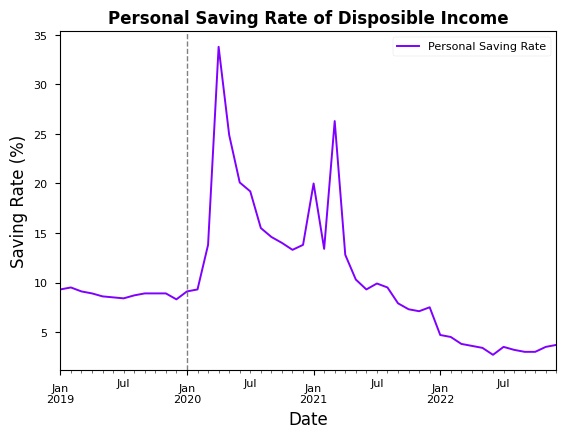

In [64]:
#fred_tickers
fred_ticker1 = "PSAVERT"  #90th to 50th percentile
fred_ticker2 = "WFRBLT01026"  #top 1%

#time interval
from_date=2019
to_date=2022

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "m")
fred_data2 = get_fred_data(fred_ticker2, "q")

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, from_date=from_date, to_date=to_date)
fred_data2 = normalize_fred_data(fred_data2, from_date=from_date, to_date=to_date)




# labels
fred_symbol = "Personal Saving Rate" ##legend
fred_symbol2 = "Top 1%" ##legend

fred_ylabel = "Saving Rate (%)"

# colours
color1 = "#7F00FF"
color2 = "magenta" # if change this to invalid you get only the other graph

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)
#ax = fred_data2.plot(kind='line', x='Date', y='value', label=fred_symbol2, color=color2)

plt.axvline(x='2020-01-01', color='grey', linestyle='--', linewidth=1)

ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('Personal Saving Rate of Disposible Income', fontsize=12, fontweight='bold') 
plt.show()

#### ALLA TRE ABOVE i en trend sedan 1900

In [42]:
fred_data

,Date,value
102,2015-01-01,29.7
103,2015-04-01,29.7
104,2015-07-01,29.9
105,2015-10-01,29.8
106,2016-01-01,29.7
107,2016-04-01,29.6
108,2016-07-01,29.5
109,2016-10-01,29.6
110,2017-01-01,29.5
111,2017-04-01,29.4


C:\Users\erik_\AppData\Local\Temp\ipykernel_3836\1572986538.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


<Figure size 2000x1000 with 0 Axes>

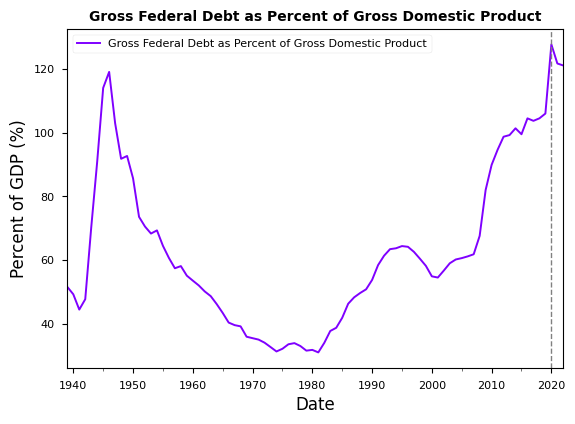

In [67]:
#fred_tickers
fred_ticker1 = "GFDGDPA188S"  #90th to 50th percentile
fred_ticker2 = "WFRBLT01026"  #top 1%

#time interval
from_date=1939
to_date=2022

# get fred_data 
fred_data = get_fred_data(fred_ticker1, "a")
fred_data2 = get_fred_data(fred_ticker2, "q")

# normalize time intervall in both series
#ticker_data, fred_data = normalize_timeseries(ticker_data, fred_data, from_date=from_date, to_date=to_date)
fred_data = normalize_fred_data(fred_data, from_date=from_date, to_date=to_date)
fred_data2 = normalize_fred_data(fred_data2, from_date=from_date, to_date=to_date)




# labels
fred_symbol = "Gross Federal Debt as Percent of Gross Domestic Product" ##legend
fred_symbol2 = "Top 1%" ##legend

fred_ylabel = "Percent of GDP (%)"

# colours
color1 = "#7F00FF"
color2 = "magenta" # if change this to invalid you get only the other graph

#figure and style
plt.figure(figsize=(20,10))
plt.style.use("seaborn-paper")

#both plots
ax = fred_data.plot(kind='line', x='Date', y='value', label=fred_symbol, color=color1)
#ax = fred_data2.plot(kind='line', x='Date', y='value', label=fred_symbol2, color=color2)

plt.axvline(x='2020-01-01', color='grey', linestyle='--', linewidth=1)

ax.set_ylabel(fred_ylabel, fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.title('Gross Federal Debt as Percent of Gross Domestic Product', fontsize=10, fontweight='bold') 
plt.show()